In [16]:
import numpy as np
import scipy
from scipy import optimize
from scipy.optimize import fmin_bfgs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [17]:
# declare model parameters
W_op = 50
N_op = 65
well_depth = 11300 #ft
rig_cost = 178.333 #$/hr
bit_size = 8.5 #in
bit_cost = 309.56 #$
trip_time = 7.3 #hrs
run_time = 12.3 #hrs
R_i = 150 #ft
R_f = 115 #ft
H_f = 0.875

# 5-spot test
W_values = [42_000, 35_000, 50_000, 35_000, 50_000]  # in lbs
N_values = [120, 80, 80, 150, 150]  # in RPM
R_values = [24, 18, 25, 27, 36]  # in ft

In [18]:
# Intermediate variables with explicit equations
C2 = (R_i / 3 - R_f / 3) / (R_f / 3 * H_f)
M1 = ((R_values[1] * W_values[2] - R_values[2] * W_values[1]) / (R_values[1] - R_values[2]) / 1_000)
M2 = ((R_values[3] * W_values[4] - R_values[4] * W_values[3]) / (R_values[3] - R_values[4]) / 1_000)
M = (M1 + M2) / 2
l1 = (np.log10(R_values[1] / R_values[4]) / np.log10(N_values[1] / N_values[4]))
l2 = (np.log10(R_values[2] / R_values[3]) / np.log10(N_values[2] / N_values[3]))
l = (l1 + l2) / 2
K = ((1 + C2 / 2 * H_f) * (R_i + R_f) / N_op**l / (W_op - M) / run_time)
D1 = (1 / bit_size)
A_f = (1_000 * (-D1 * W_op + 10) / (3 + 3) / (2 * N_op + 0.000087 * N_op**3) * (H_f + 6 / 2 * H_f**2))
E1 = (bit_cost + rig_cost * trip_time)
E2 = (1_000 / A_f * (1 + 6 / 2))
E3 = (1_000 * K / A_f * (6 / C2 + (C2 - 6) / C2**2 * np.log(1 + C2)))

# Drill cost function
def drill_cost(x):
    return (E1 + rig_cost * E2 * (-D1 * x[0] + 10) / (2 * x[1] + 0.000087 * x[1]**3)) / (
            E3 * (x[0] - M) * (-D1 * x[0] + 10) / (2 * x[1]**(1 - l) + 0.000087 * x[1]**(3 - l)))

In [19]:
#create a surface plot to assess function behavior 

def create_surface_plot():
    x = np.arange(30, 80)
    y = np.arange(50, 120)
    xgrid, ygrid = np.meshgrid(x, y)
    xy = np.stack([xgrid, ygrid])

    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(45,-90)
    surf = ax.plot_surface(xgrid, ygrid, drill_cost(xy), cmap='tab20b')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('drill_cost(x, y)')
    fig.colorbar(surf, shrink=0.5, aspect=7)

    plt.show()

In [20]:
#perform optimization
def run_optimization():
    x0 = np.array([70, 85])
    res = scipy.optimize.fmin_bfgs(drill_cost, x0, fprime=None, args=(), gtol=1e-05, epsilon=1.4901161193847656e-08, maxiter=None, full_output=0, disp=1, retall=True, callback=None)
    return res

In [21]:
# Create two separate lists containing the values of W and N at each iteration
def optimization_path(res):
    listx=[]
    listy=[]
    for i in range(0, len(res[1])):
        listx.append(res[1][i][0])
        listy.append(res[1][i][1])
    return listx, listy
 
# Create the contour plot
def create_contour_plot():
    i1 = np.arange(30, 80, 3)
    i2 = np.arange(50, 120, 3)
    x1_mesh, x2_mesh = np.meshgrid(i1, i2)
    f_mesh = (E1 + rig_cost * E2 * (-D1 * x1_mesh + 10) / (2 * x2_mesh + 0.000087 * x2_mesh**3)) / (E3 * (x1_mesh - M) * (-D1 * x1_mesh + 10) / (2 * x2_mesh**(1 - l) + 0.000087 * x2_mesh**(3 - l)))
    plt.figure()
    
    # Specify contour lines
    lines = range(1,52,1)
    # Plot contours
    CS = plt.contour(x1_mesh, x2_mesh, f_mesh,lines)
    # Label contours
    plt.clabel(CS, inline=1, fontsize=10)
    # Add some text to the plot
    plt.title('Drill cost function contour plot')
    plt.xlabel('W (lbs)')
    plt.ylabel('N (rpm)')

    plt.plot(listx,listy,'r-o')

    # Show the plot
    plt.show()

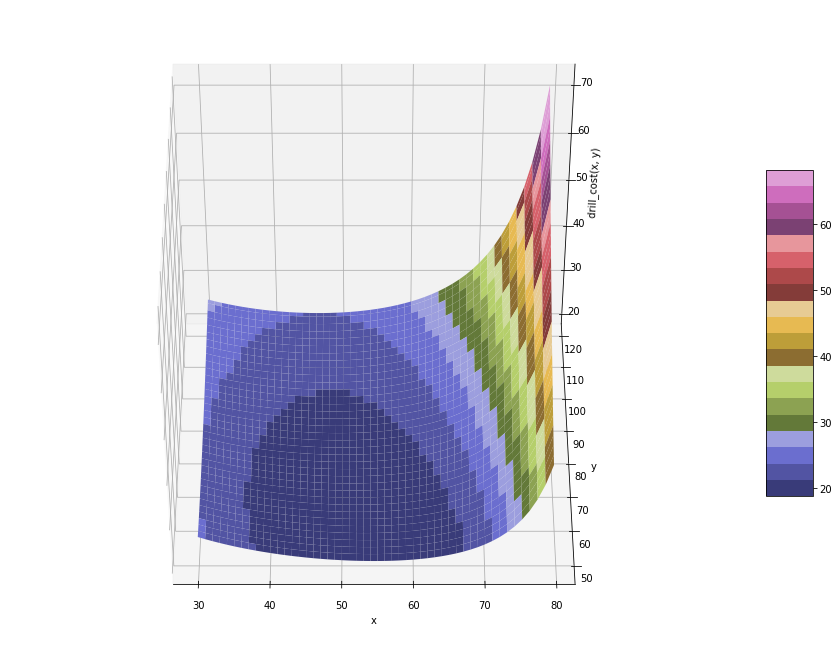

Optimization terminated successfully.
         Current function value: 18.796534
         Iterations: 19
         Function evaluations: 80
         Gradient evaluations: 20
The optimum weight on bit (W) is 54.16 lb, and the optimum rotary speed (N) is 52.02 RPM, for a minimum drill cost of $18.80/ft


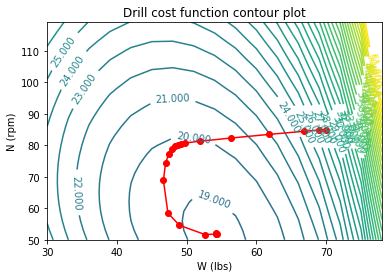

In [22]:
# Main program
create_surface_plot()
res = run_optimization()
print("The optimum weight on bit (W) is {:.2f} lb, and the optimum rotary speed (N) is {:.2f} RPM, for a minimum drill cost of ${:.2f}/ft".format(res[0][0], res[0][1], drill_cost(res[0])))
listx, listy = optimization_path(res)
create_contour_plot()